Evaluation for BERT

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

In [2]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions


SAVE_EVAL_RESULTS = True

In [3]:
DATASET_SIZE = 120
DATASET_IS_BALANCED = True

training_name = 'bert-finetune_{}k_{}'.format(
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal'
)

training_args_datetime = datetime(year=2023, month=12, day=17)
training_storing_folder = Path(training_name).resolve()

In [4]:
# load validation dataset. Same for all models

X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_validation_dataset()

Loaded validation dataset

Validation dataset imbalanced class distribution
review_score
1    774377
0    150928
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
0    150672
1    150672
Name: count, dtype: int64





In [5]:
# rerun this cell if want to evaluate a new model

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 120k, is_balanced: True

Training dataset class distribution
review_score
0    54060
1    53940
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    6060
0    5940
Name: count, dtype: int64





In [6]:
# data cleaning function

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))

    return str_arr

In [7]:
# rerun this cell if want to evaluate a new model

X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

In [8]:
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

In [9]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [10]:
print('training set')
print(X_train.shape)
print(y_train.shape)
print()
print('testing set')
print(X_test.shape)
print(y_test.shape)


training set
(108000,)
(108000,)

testing set
(12000,)
(12000,)


In [11]:
# create dataset

from datasets import Dataset

ds_test = Dataset.from_dict({
    'text': [str(s) for s in list(X_test.to_numpy().flatten())],
    'label': list(y_test)
})

ds_imbal_valid = Dataset.from_dict({
    'text': [str(s) for s in list(X_imbal_valid.to_numpy().flatten())],
    'label': list(y_imbal_valid)
})

ds_bal_valid = Dataset.from_dict({
    'text': [str(s) for s in list(X_bal_valid.to_numpy().flatten())],
    'label': list(y_bal_valid)
})

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    return tokenizer(data["text"], padding='max_length', max_length=tokenizer.model_max_length, truncation=True)

# apply tokenizer to the dataset
ds_test = ds_test.map(tokenize_dataset, batched=True)
ds_imbal_valid = ds_imbal_valid.map(tokenize_dataset, batched=True)
ds_bal_valid = ds_bal_valid.map(tokenize_dataset, batched=True)

Map: 100%|██████████| 301344/301344 [00:28<00:00, 10498.85 examples/s]


Load the models

Trainer class ??

In [13]:
BATCH_SIZE = 32

model_path = Path.joinpath(
        training_storing_folder, 
        '{}_{}_model'.format(training_name, training_args_datetime.strftime('%Y-%m-%d')))

In [14]:
import evaluate

metric_acc = evaluate.load("accuracy")
metric_recall = evaluate.load('recall')
metric_f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred      # logits: an n*num_of_class array with probability, e.g. [[ 1.9851098, -1.6966375],[ 2.7240963, -2.372472 ],...], labels = true labels
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)['accuracy']
    recall = metric_recall.compute(predictions=predictions, references=labels)['recall']
    f1_score = metric_f1.compute(predictions=predictions, references=labels, pos_label=1)['f1']
    # rocauc = metric_rocauc.compute(predictions=predictions, references=labels)['roc_auc']
    return {'accuracy': acc, "recall": recall, "f1": f1_score}

2023-12-20 20:35:57.469875: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 20:35:57.621933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 20:35:57.621959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 20:35:57.622747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 20:35:57.691918: I tensorflow/core/platform/cpu_feature_g

In [15]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

trainer_args = TrainingArguments(output_dir='eval',
    per_device_eval_batch_size=BATCH_SIZE)

trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(
        model_path),
    args=trainer_args,
    # train_dataset=ds_test,
    # eval_dataset=ds_test,
    compute_metrics=compute_metrics
)

Evaluation

In [5]:
# create folders for storing evaluation metrics

eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

In [ ]:
ds_test_result = trainer.predict(ds_test)

In [ ]:
ds_test_result

PredictionOutput(predictions=array([[-1.4671457 ,  1.403239  ],
       [ 0.94431484, -1.235694  ],
       [-1.7848498 ,  1.0498815 ],
       ...,
       [ 0.25248408, -0.7436442 ],
       [ 3.1993358 , -2.399864  ],
       [-1.0458024 ,  0.4455899 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 0, 0, 1]), metrics={'test_loss': 0.22522546350955963, 'test_accuracy': 0.91075, 'test_recall': 0.8953795379537954, 'test_f1': 0.9101736140233163, 'test_runtime': 55.949, 'test_samples_per_second': 214.481, 'test_steps_per_second': 6.703})

In [ ]:
from scipy.special import softmax

y_test_pred_prob_raw = softmax(ds_test_result.predictions, axis=1)

y_test_pred = ds_test_result.label_ids

y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])


In [ ]:
# save all three numpy arrays to disk

np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'), y_test_pred_prob_raw)
np.save(Path.joinpath(eval_test_folder, 'y_test_pred.npy'), y_test_pred)
np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'), y_test_pred_prob)
np.save(Path.joinpath(eval_test_folder, 'y_test_true.npy'), y_test)

In [ ]:
# load the numpy arrays from disk

y_test_pred_prob_raw = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'))
y_test_pred = np.load(Path.joinpath(eval_test_folder, 'y_test_pred.npy'))
y_test_pred_prob = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'))
y_test = np.load(Path.joinpath(eval_test_folder, 'y_test_true.npy'))

In [ ]:
test_classification_report_dict = evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5940
           1       1.00      1.00      1.00      6060

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



TN - True Negative 5940
FN - False Negative 0
TP - True Positive 6060
FP - False Positive 0
Accuracy Rate: 1.0
Misclassification Rate: 0.0
F1-Score: 1.0
ROC-AUC 1.0


In [ ]:
test_classification_report_dict

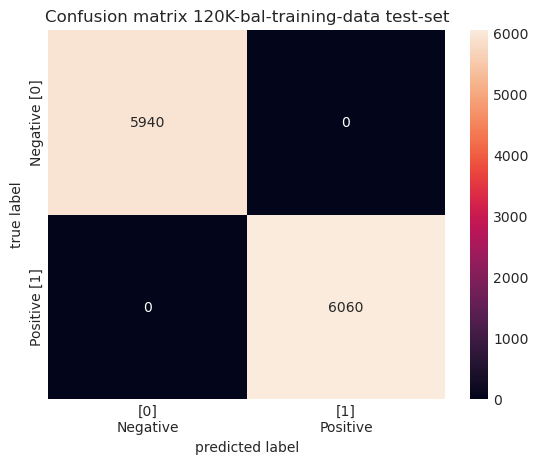

In [ ]:
import matplotlib as plt
plt.style.use('seaborn-v0_8-dark')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'confusion_matrix_test.png')
)

0.5949967635652453


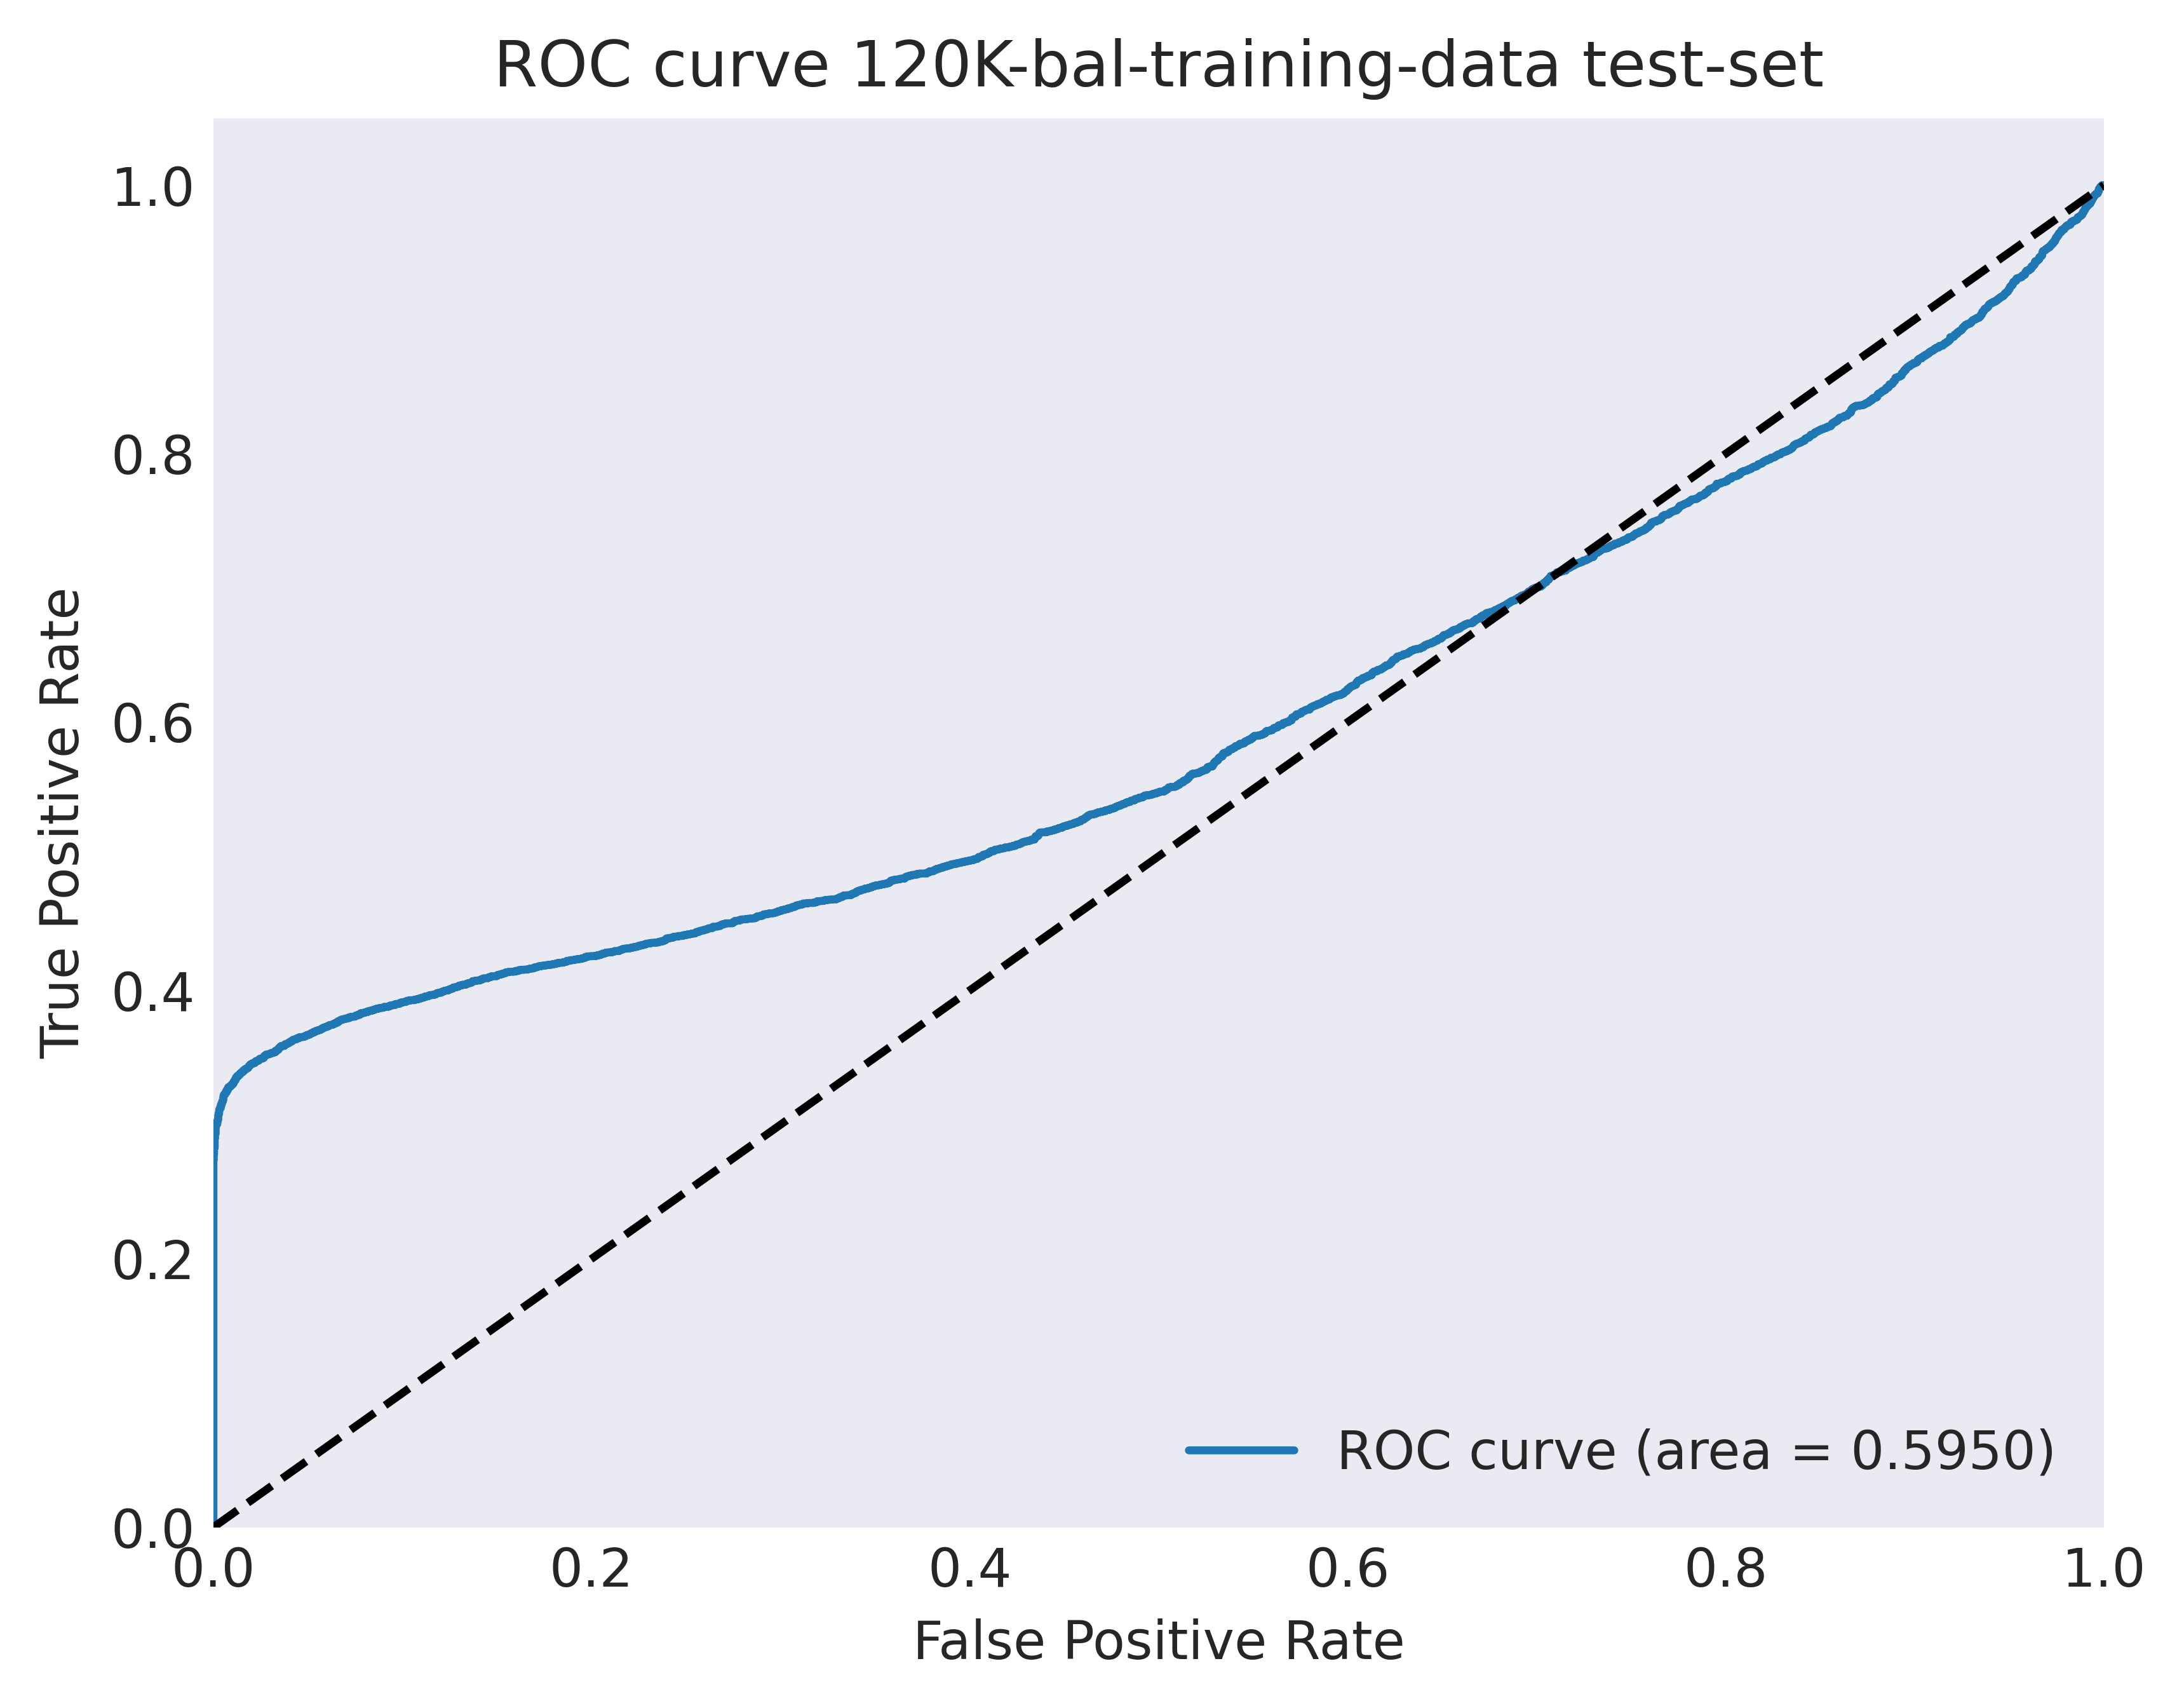

In [ ]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'roc_curve_test.png')
)

In [ ]:
from sklearn.metrics import roc_auc_score

# import importlib
# importlib.reload(evaluation_functions)

# add ROC area to report_dict
test_classification_report_dict['roc_auc'] = roc_auc_score(y_test, y_test_pred_prob)

test_report_df = evaluation_functions.create_classification_report_df(
    test_classification_report_dict, 
    training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    test_report_df.to_csv(Path.joinpath(eval_test_folder, "{}_{}_test_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed balancd validation set

In [ ]:
ds_bal_valid_result = trainer.predict(ds_bal_valid)

KeyboardInterrupt: 

In [ ]:
from scipy.special import softmax

y_bal_valid_pred_prob_raw = softmax(ds_bal_valid_result.predictions, axis=1)

y_bal_valid_pred = ds_bal_valid_result.label_ids

y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])


In [ ]:
# save all three numpy arrays to disk

np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'), y_bal_valid_pred_prob_raw)
np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'), y_bal_valid_pred)
np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'), y_bal_valid_pred_prob)
np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'), y_bal_valid)

In [ ]:
# load the numpy arrays from disk

y_bal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'))
y_bal_valid_pred = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'))
y_bal_valid_pred_prob = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'))
y_bal_valid = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'))

In [ ]:
bal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

In [ ]:
bal_valid_classification_result_dict

In [ ]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'confusion_matrix_valid_bal.png')
)

In [ ]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'roc_curve_valid_bal.png')
)

In [ ]:
# add ROC area to report_dict
bal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_bal_valid, y_bal_valid_pred_prob)

bal_valid_report_df = evaluation_functions.create_classification_report_df(bal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    bal_valid_report_df.to_csv(Path.joinpath(eval_valid_bal_folder, "{}_{}_valid_bal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed imbalanced validation set

In [17]:
ds_imbal_valid_result = trainer.predict(ds_imbal_valid)

In [18]:
from scipy.special import softmax

y_imbal_valid_pred_prob_raw = softmax(ds_imbal_valid_result.predictions, axis=1)

y_imbal_valid_pred = ds_imbal_valid_result.label_ids

y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])


In [19]:
# save all three numpy arrays to disk

np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'), y_imbal_valid_pred_prob_raw)
np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'), y_imbal_valid_pred)
np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'), y_imbal_valid_pred_prob)
np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'), y_imbal_valid)

In [6]:
# load the numpy arrays from disk

y_imbal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'))
y_imbal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'))
y_imbal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'))
y_imbal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'))

In [7]:
imbal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    150928
           1       1.00      1.00      1.00    774377

    accuracy                           1.00    925305
   macro avg       1.00      1.00      1.00    925305
weighted avg       1.00      1.00      1.00    925305



TN - True Negative 150928
FN - False Negative 0
TP - True Positive 774377
FP - False Positive 0
Accuracy Rate: 1.0
Misclassification Rate: 0.0
F1-Score: 1.0
ROC-AUC 1.0


In [8]:
imbal_valid_classification_result_dict

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 150928.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 774377.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 925305.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 925305.0}}

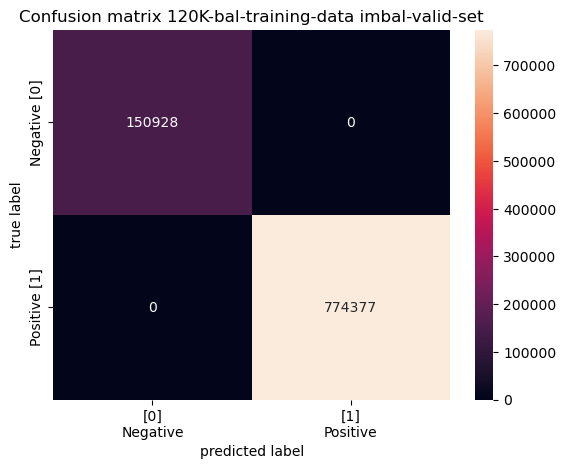

In [9]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'confusion_matrix_valid_imbal.png')
)

0.5911586634467314


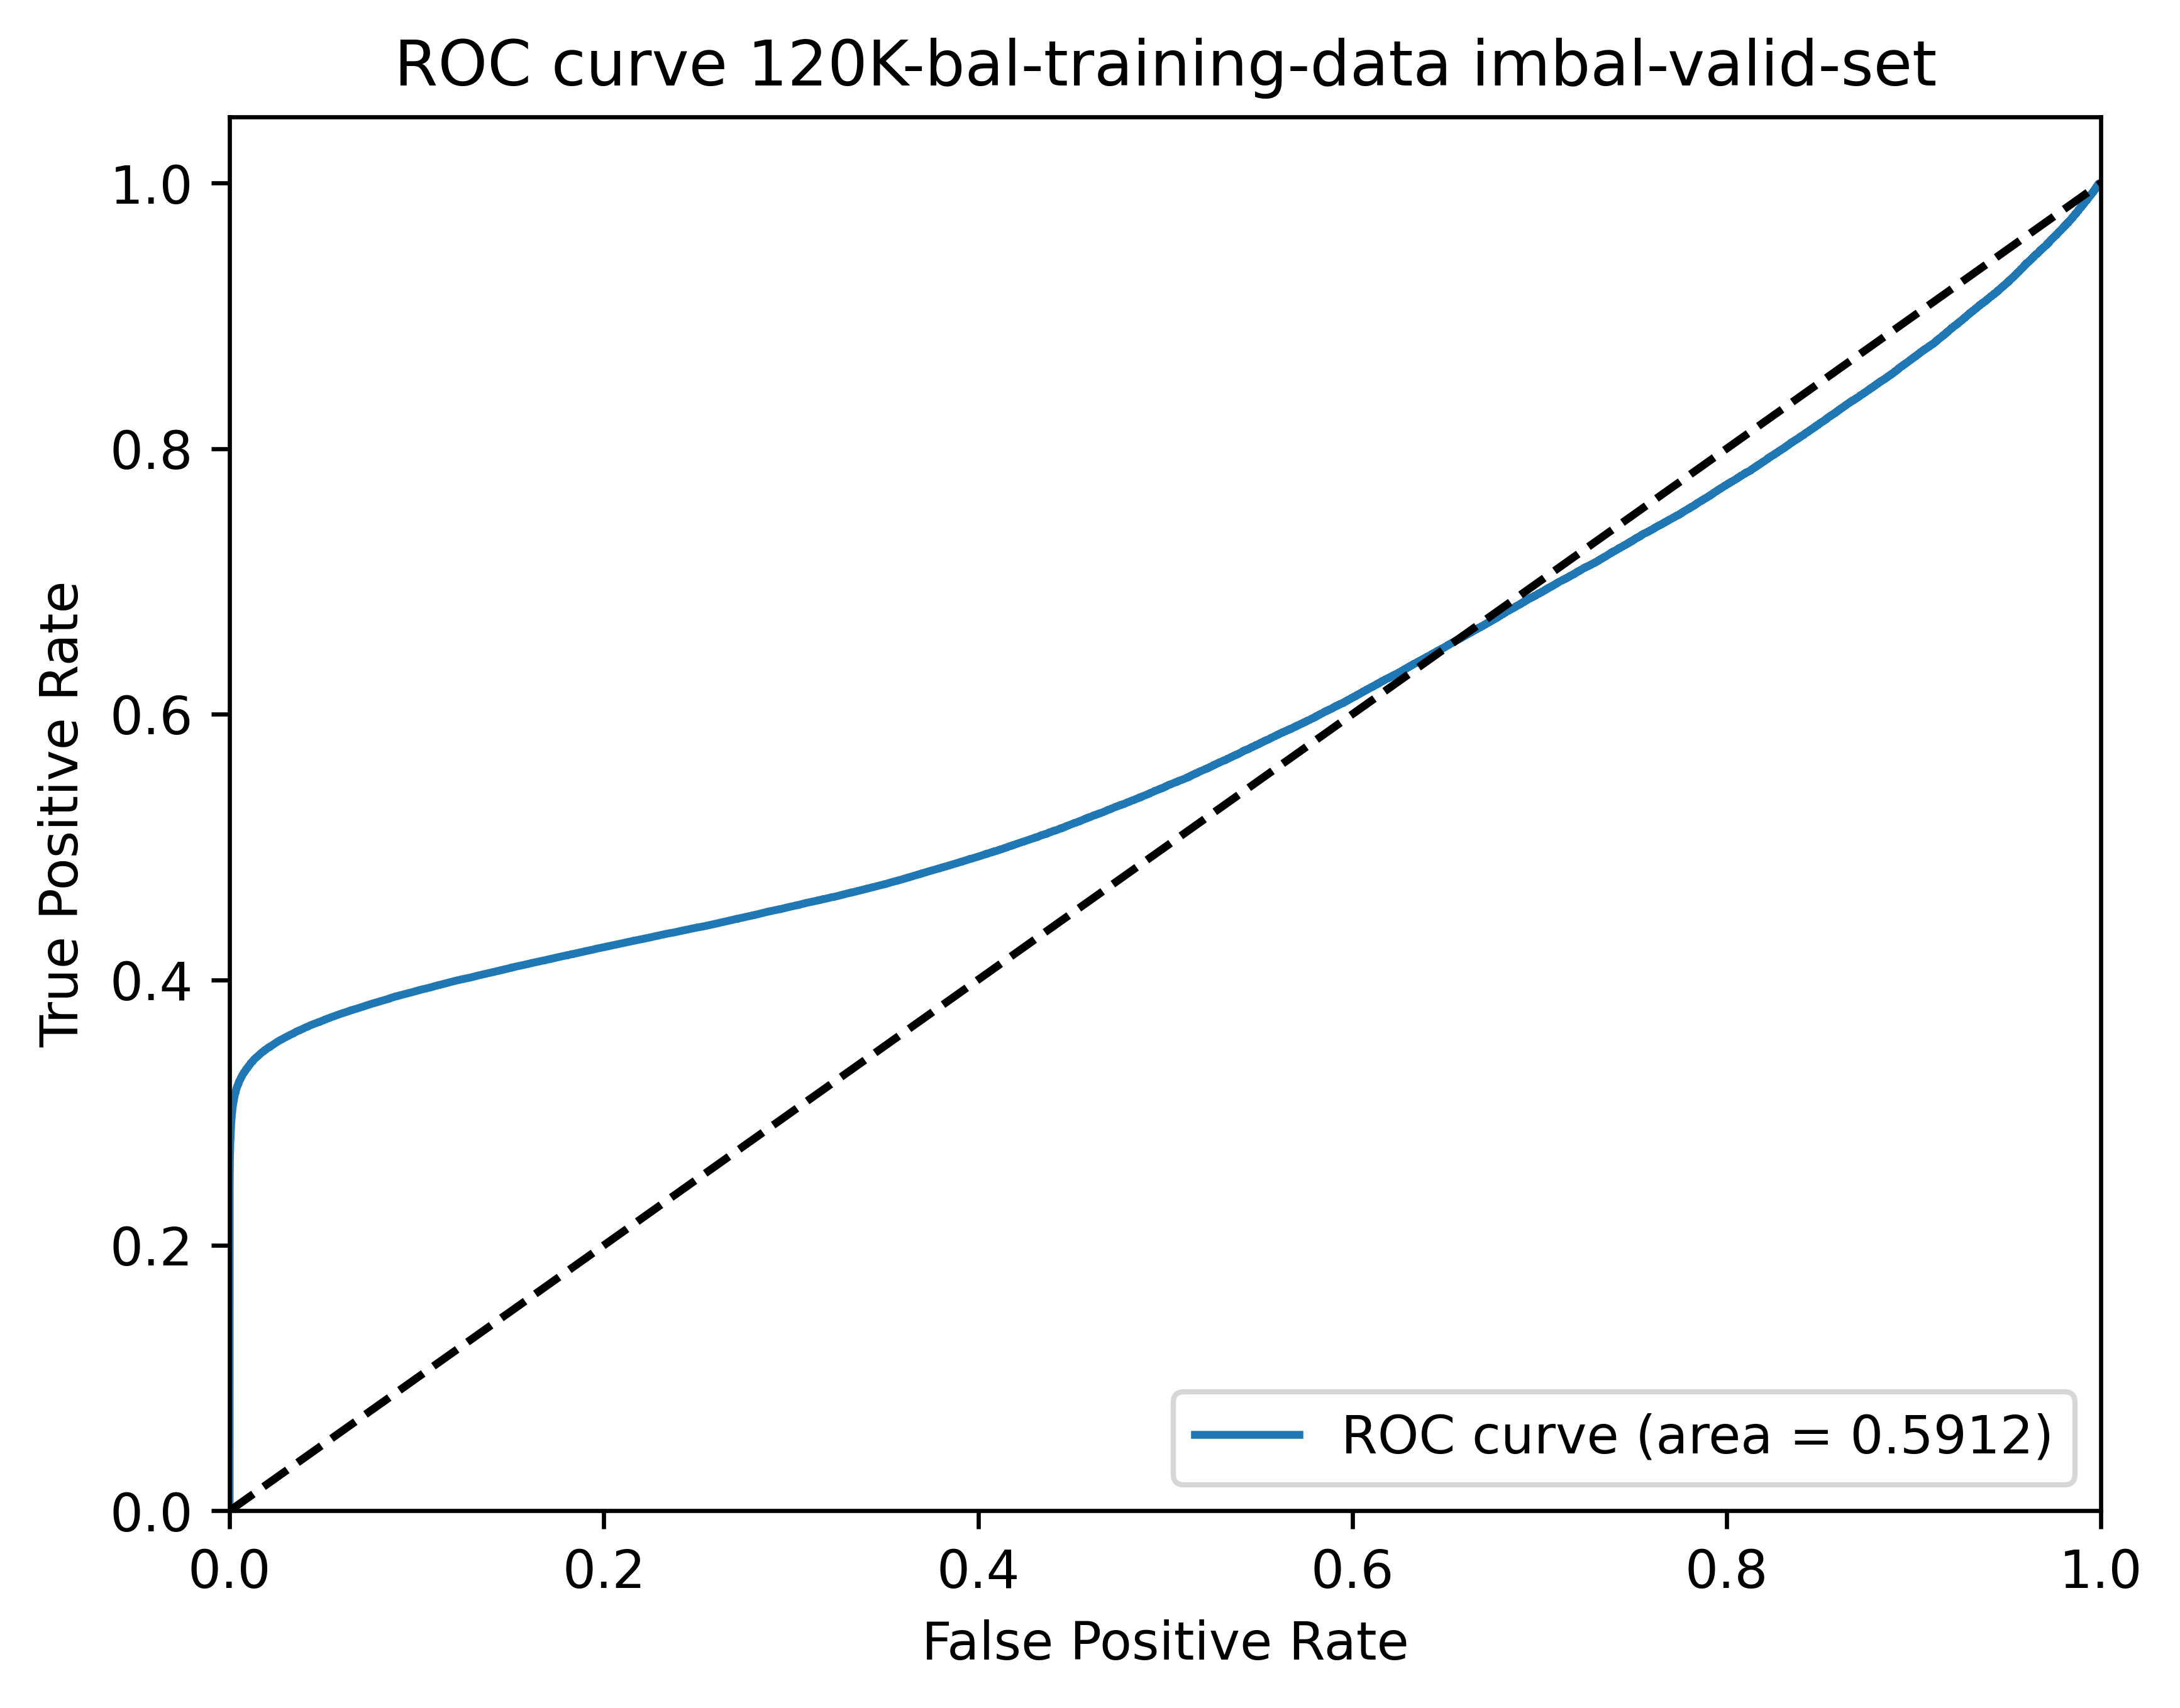

In [10]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'roc_curve_valid_imbal.png')
)

In [13]:
# add ROC area to report_dict

from sklearn.metrics import roc_auc_score

imbal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_imbal_valid, y_imbal_valid_pred_prob)

imbal_valid_report_df = evaluation_functions.create_classification_report_df(imbal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    imbal_valid_report_df.to_csv(Path.joinpath(eval_valid_imbal_folder, "{}_{}_valid_imbal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

evaluation end